In [1]:
# Import Modules
import requests
from bs4 import BeautifulSoup
import re
import time
from datetime import datetime, timedelta
import plotly.graph_objects as go
import plotly.subplots as ms
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import streamlit as st
from datetime import datetime, timedelta
from pykrx import stock
from pykrx import bond
import seaborn as sns
import scipy.optimize as opt
from scipy.optimize import minimize

import yfinance as yf
from deap import base, creator, tools, algorithms
from scipy.stats import norm
from pyswarm import pso
import cma

import warnings
warnings.filterwarnings(action='ignore')

# plot 설정
plt.rc('font', family ='Malgun Gothic') # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False #마이너스 기호 깨짐 방지

In [2]:
# ETF 목록
etf_list = [
    "XLK", "VGT", "XLF", "VFH", "XLV", "VHT", "XLE", "VDE",
    "XLI", "VIS", "XLY", "VCR", "XLP", "VDC", "XLC", "VOX",
    "XLU", "VPU", "XLRE", "VNQ", "BND", "AGG", "LQD", "HYG",
    "IEF", "GLD", "IAU", "SLV", "USO", "DBO", "VNQ", "REET",
    "IYR", "UUP", "FXE", "FXY", "FXB", "FXC"
]

In [3]:
etf_info = {
    "XLK": "Technology",
    "VGT": "Technology",
    "XLF": "Financials",
    "VFH": "Financials",
    "XLV": "Health Care",
    "VHT": "Health Care",
    "XLE": "Energy",
    "VDE": "Energy",
    "XLI": "Industrials",
    "VIS": "Industrials",
    "XLY": "Consumer Discretionary",
    "VCR": "Consumer Discretionary",
    "XLP": "Consumer Staples",
    "VDC": "Consumer Staples",
    "XLC": "Communication Services",
    "VOX": "Communication Services",
    "XLU": "Utilities",
    "VPU": "Utilities",
    "XLRE": "Real Estate",
    "VNQ": "Real Estate",
    "BND": "Bonds",
    "AGG": "Bonds",
    "LQD": "Corporate Bonds",
    "HYG": "High Yield Bonds",
    "IEF": "Treasury Bonds",
    "GLD": "Gold",
    "IAU": "Gold",
    "SLV": "Silver",
    "USO": "Oil",
    "DBO": "Oil",
    "REET": "Real Estate",
    "IYR": "Real Estate",
    "UUP": "Currency",
    "FXE": "Currency",
    "FXY": "Currency",
    "FXB": "Currency",
    "FXC": "Currency"
}

etf_info_df = pd.DataFrame(list(etf_info.items()), columns=['Ticker', 'Sector'])
#etf_info_df.to_csv("ticker_etf.csv")


In [4]:
data = pd.read_csv("C:/Users/koby0/OneDrive/바탕 화면/학습데이터/merged_data.csv")
data.tail()
etf_data = data.copy()

In [5]:
# # 일별 수익률 계산
# returns = data.pct_change().dropna()
# # 변동성 (연율화된 표준편차) 계산
# volatility = returns.std() * np.sqrt(252)

# 포트폴리오 함수 & 시각화

     ETF        Weight
0    VGT  9.035018e-21
1    XLF  5.976101e-17
2    VFH  0.000000e+00
3    XLV  0.000000e+00
4    VHT  0.000000e+00
5    XLE  2.625263e-17
6    VDE  0.000000e+00
7    XLI  0.000000e+00
8    VIS  4.656100e-18
9    XLY  1.701106e-17
10   VCR  9.614683e-18
11   XLP  1.845980e-17
12   VDC  6.456013e-18
13   XLC  1.277676e-17
14   VOX  0.000000e+00
15   XLU  0.000000e+00
16   VPU  3.496665e-17
17  XLRE  0.000000e+00
18   VNQ  1.090962e-17
19   BND  1.563573e-02
20   AGG  1.423690e-02
21   LQD  0.000000e+00
22   HYG  1.183607e-18
23   IEF  2.388427e-02
24   GLD  0.000000e+00
25   IAU  0.000000e+00
26   SLV  0.000000e+00
27   USO  3.772744e-04
28   DBO  3.739236e-17
29  REET  0.000000e+00
30   IYR  2.596678e-17
31   UUP  4.336389e-01
32   FXE  2.905155e-01
33   FXY  7.253019e-02
34   FXB  2.359129e-02
35   FXC  1.255899e-01


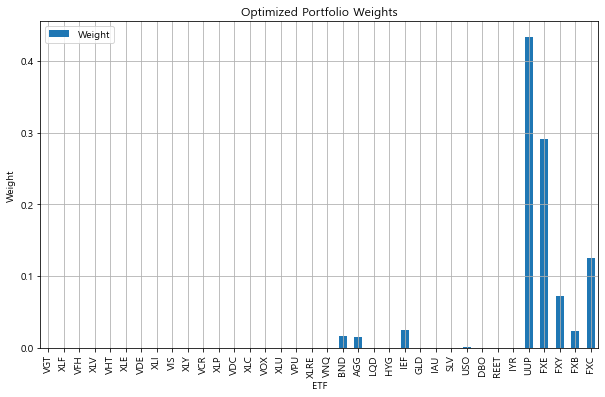

In [6]:
def optimize_portfolio(etf_data, risk_aversion_factor):
    # Extract ETF tickers and returns
    etf_returns_columns = [col for col in etf_data.columns if '7_Day_Percent_Change_' in col]
    etf_tickers = [col.replace('7_Day_Percent_Change_', '') for col in etf_returns_columns]
    returns = etf_data[etf_returns_columns] / 100  # Convert percentage to decimal

    def portfolio_volatility(weights, returns):
        portfolio_return = np.dot(weights, returns.mean() * 252)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
        return portfolio_volatility

    # 제약 조건과 초기 가중치 설정
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(etf_tickers)))
    initial_weights = np.array([1/len(etf_tickers)] * len(etf_tickers))

    # 최적화 수행
    optimal_weights = minimize(portfolio_volatility, initial_weights, args=(returns,),
                               method='SLSQP', bounds=bounds, constraints=constraints)

    # 결과 가중치
    weights = optimal_weights.x

    # 포트폴리오 데이터프레임 생성
    portfolio = pd.DataFrame({'ETF': etf_tickers, 'Weight': weights})

    return portfolio

# 포트폴리오 가중치 시각화 함수
def plot_portfolio_weights(portfolio):
    fig, ax = plt.subplots(figsize=(10, 6))
    portfolio.set_index('ETF').plot(kind='bar', ax=ax)
    ax.set_ylabel('Weight')
    ax.set_title('Optimized Portfolio Weights')
    plt.grid(True)
    plt.show()

# 사용 예시
etf_data = data
risk_aversion_factor = 2  # 예시 위험 회피 계수

# 포트폴리오 최적화 함수 호출
optimized_portfolio = optimize_portfolio(etf_data, risk_aversion_factor)

# 결과 출력
print(optimized_portfolio)

# 포트폴리오 가중치 시각화
plot_portfolio_weights(optimized_portfolio)


최적화된 포트폴리오 비중: {'VGT': 0.0, 'XLF': 0.0, 'VFH': 0.0, 'XLV': 1.0, 'VHT': 0.0}
샤프 비율: -0.29827702079669555


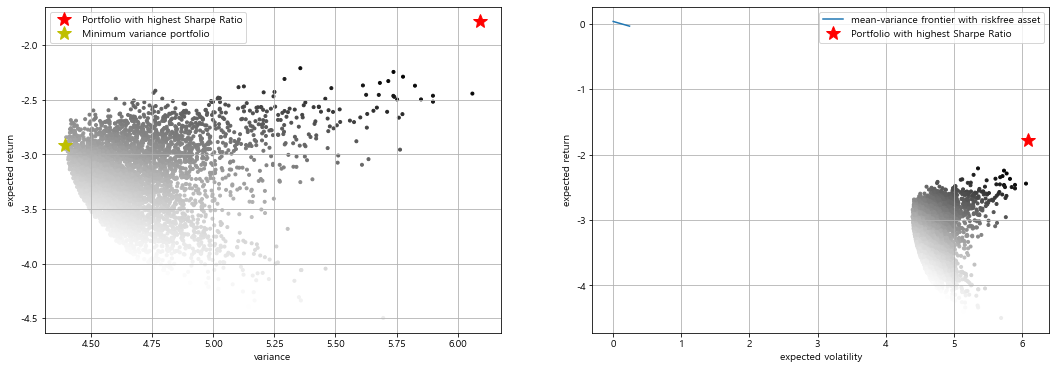

In [7]:
# 백테스팅 함수 정의
def back_test(codes, weight, start_date, end_date, etf_data):
    # 포트폴리오 df 생성
    portfolio_df = pd.DataFrame()
    for code in codes:
        column_name = f'7_Day_Percent_Change_{code}'
        if column_name not in etf_data.columns:
            raise KeyError(f"'{column_name}' not in ETF data columns")
        temp = etf_data[['Date', column_name]]
        temp = temp[(temp['Date'] >= start_date) & (temp['Date'] <= end_date)].set_index('Date')
        temp.rename(columns={column_name: code}, inplace=True)
        portfolio_df = pd.concat([portfolio_df, temp], axis=1)
    
    # 로그 수익률 계산
    log_ret = portfolio_df.apply(np.log).diff().dropna()
    log_returns = log_ret.cumsum(axis=0).iloc[-1]
    portfolioLogReturn = np.sum(log_returns * weight)

    # 변동성 계산
    cov_matrix = log_ret.cov() * len(log_ret)
    port_variance = np.dot(weight.T, np.dot(cov_matrix, weight))
    port_volatility = np.sqrt(port_variance)

    percent_var = str(round(port_variance * 100, 2)) + '%'
    percent_vols = str(round(port_volatility * 100, 2)) + '%'
    percent_ret = str(round(portfolioLogReturn * 100, 2)) + '%'

    return log_ret, portfolio_df, percent_ret, percent_vols, percent_var

# 평균수익률과 표준편차 반환하기 위한 함수
def ret_std(weight, ret, log_ret):
    port_mean = np.sum(weight * ret.mean() * len(log_ret))
    port_var = np.dot(weight.T, np.dot(ret.cov() * len(log_ret), weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

# 포트폴리오 수익률과 volatility, sharpe ratio 반환하는 함수
def statistics(weights, ret, log_ret, rf=0):
    weights = np.array(weights)
    pret = np.sum(ret.mean() * weights) * len(log_ret) - rf
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * len(log_ret), weights)))
    return np.array([pret, pvol, pret / pvol])

# -sharpe ratio 반환하는 함수
def min_func_sharpe(weights, ret, log_ret, rf=0):
    return -statistics(weights, ret, log_ret, rf)[2]

# volatility^2 반환하는 함수
def min_func_volatility(weights, ret, log_ret):
    return statistics(weights, ret, log_ret)[1] ** 2

# 랜덤하게 5000개의 포트폴리오를 생성하고 구성종목의 비중을 랜덤하게 부여하는 함수
def make_random_portfolio(ret, noa, log_ret):
    port_rets = []
    port_std = []
    for _ in range(5000):
        weight = np.random.random(noa)
        weight /= np.sum(weight)
        mu, sig = ret_std(np.array(weight), ret, log_ret)
        port_rets.append(mu)
        port_std.append(sig)
    return port_rets, port_std

# 포트폴리오 최적화 및 시각화 함수
def portfolio_opt(port_rets, port_std, noa, ret, portfolio_df, log_ret, end_date):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for _ in range(noa))
    k = noa * [1. / noa,]

    opts = minimize(min_func_sharpe, k, method='SLSQP', bounds=bnds, constraints=cons, args=(ret, log_ret))
    optv = minimize(min_func_volatility, k, method='SLSQP', bounds=bnds, constraints=cons, args=(ret, log_ret))

    axes[0].scatter(port_std, port_rets, c=np.array(port_rets) / np.array(port_std), marker='.', cmap='Greys')
    axes[0].plot(statistics(opts['x'], ret, log_ret)[1], statistics(opts['x'], ret, log_ret)[0], 'r*', markersize=15.0, label='Portfolio with highest Sharpe Ratio')
    axes[0].plot(statistics(optv['x'], ret, log_ret)[1], statistics(optv['x'], ret, log_ret)[0], 'y*', markersize=15.0, label='Minimum variance portfolio')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_xlabel('variance')
    axes[0].set_ylabel('expected return')

    rf = 0.035  # Example risk-free rate
    slope = (statistics(opts['x'], ret, log_ret)[0] - rf) / statistics(opts['x'], ret, log_ret)[1]
    x = np.linspace(0.0, 0.24, 5000)
    y = [i * slope + rf for i in x]

    axes[1].scatter(port_std, port_rets, c=np.array(port_rets) / np.array(port_std), marker='.', cmap='Greys')
    axes[1].plot(x, y, label='mean-variance frontier with riskfree asset')
    axes[1].plot(statistics(opts['x'], ret, log_ret)[1], statistics(opts['x'], ret, log_ret)[0], 'r*', markersize=15.0, label='Portfolio with highest Sharpe Ratio')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_xlabel('expected volatility')
    axes[1].set_ylabel('expected return')

    sharpe_ratio = statistics(opts['x'], ret, log_ret, rf)[2]
    opt_weight = {portfolio_df.columns[i]: round(opts['x'][i], 10) for i in range(noa)}

    return fig, sharpe_ratio, opt_weight

# 사용 예시
etf_data = data
etf_data['Date'] = pd.to_datetime(etf_data['Date'])  # Ensure the Date column is in datetime format

etf_returns_columns = [col for col in etf_data.columns if '7_Day_Percent_Change_' in col]
etf_tickers = [col.replace('7_Day_Percent_Change_', '') for col in etf_returns_columns]

start_date = '2019-01-04'
end_date = '2020-01-04'


risk_aversion_factor = 2
codes = etf_tickers[:5] # 예시로 처음 5개의 ETF 선택
# codes =["UUP", "FXE", "FXY", "FXC"]
weights = np.array([0.2] * 5)  # 예시로 각 ETF에 동일한 비중 할당

# 백테스팅 함수 호출
log_ret, portfolio_df, percent_ret, percent_vols, percent_var = back_test(codes, weights, start_date, end_date, etf_data)

# 랜덤 포트폴리오 생성 및 최적화
port_rets, port_std = make_random_portfolio(log_ret, len(codes), log_ret)
fig, sharpe_ratio, opt_weight = portfolio_opt(port_rets, port_std, len(codes), log_ret, portfolio_df, log_ret, pd.to_datetime(end_date))

# 결과 출력
print(f"최적화된 포트폴리오 비중: {opt_weight}")
print(f"샤프 비율: {sharpe_ratio}")
plt.show()


포트폴리오 수익률: 0.06%
포트폴리오 변동성: 4.57%
포트폴리오 분산: 0.21%


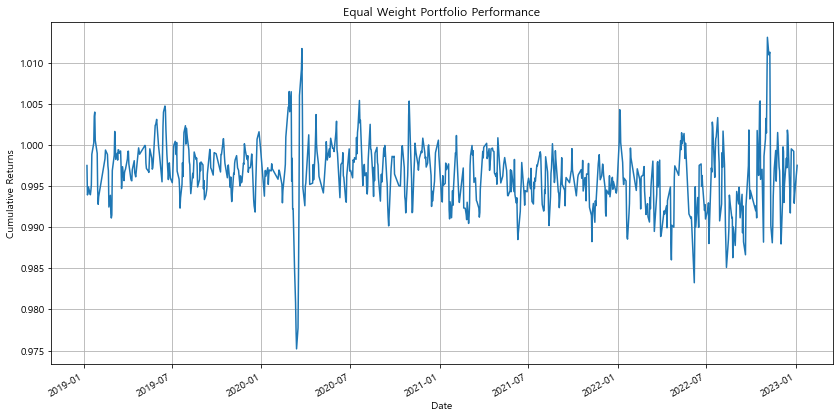

In [8]:
def equal_weight_portfolio(etf_data, codes, start_date, end_date):
    # 날짜 형식 맞추기
    etf_data['Date'] = pd.to_datetime(etf_data['Date'])
    
    # 데이터 필터링
    filtered_data = etf_data[(etf_data['Date'] >= start_date) & (etf_data['Date'] <= end_date)]
    filtered_data.set_index('Date', inplace=True)

    # 포트폴리오 df 생성
    portfolio_df = pd.DataFrame()
    for code in codes:
        column_name = f'7_Day_Percent_Change_{code}'
        if column_name not in filtered_data.columns:
            raise KeyError(f"'{column_name}' not in ETF data columns")
        portfolio_df[code] = filtered_data[column_name]
    
    # 등가중 포트폴리오
    weight = np.array([1/len(codes)] * len(codes))

    # 로그 수익률 계산
    log_ret = np.log(portfolio_df / 100 + 1).diff().dropna()
    portfolio_log_returns = log_ret.dot(weight)

    # 변동성 계산
    cov_matrix = log_ret.cov() * 252  # 연간 변동성으로 변환
    port_variance = np.dot(weight.T, np.dot(cov_matrix, weight))
    port_volatility = np.sqrt(port_variance)

    percent_var = str(round(port_variance * 100, 2)) + '%'
    percent_vols = str(round(port_volatility * 100, 2)) + '%'
    percent_ret = str(round(portfolio_log_returns.sum() * 100, 2)) + '%'

    return log_ret, portfolio_df, percent_ret, percent_vols, percent_var, portfolio_log_returns

# 사용 예시
etf_data = data
codes = ["UUP", "FXE", "FXY", "FXC"]  # 예시로 일부 ETF 사용
start_date = '2019-01-04'
end_date = '2023-01-04'

log_ret, portfolio_df, percent_ret, percent_vols, percent_var, portfolio_log_returns = equal_weight_portfolio(etf_data, codes, start_date, end_date)

# 포트폴리오 결과 출력
print(f"포트폴리오 수익률: {percent_ret}")
print(f"포트폴리오 변동성: {percent_vols}")
print(f"포트폴리오 분산: {percent_var}")

# 시각화
def plot_portfolio_performance(portfolio_log_returns):
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # 포트폴리오 가치 계산
    cumulative_returns = (portfolio_log_returns + 1).cumprod()
    cumulative_returns.plot(ax=ax, title='Equal Weight Portfolio Performance')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Returns')
    plt.grid(True)
    plt.show()

# 포트폴리오 성과 시각화
plot_portfolio_performance(portfolio_log_returns)


최적화된 포트폴리오 비중: {'UUP': 0.0, 'FXE': 0.0, 'FXY': 1.0, 'FXC': 0.0}
샤프 비율: -0.15246279317095698


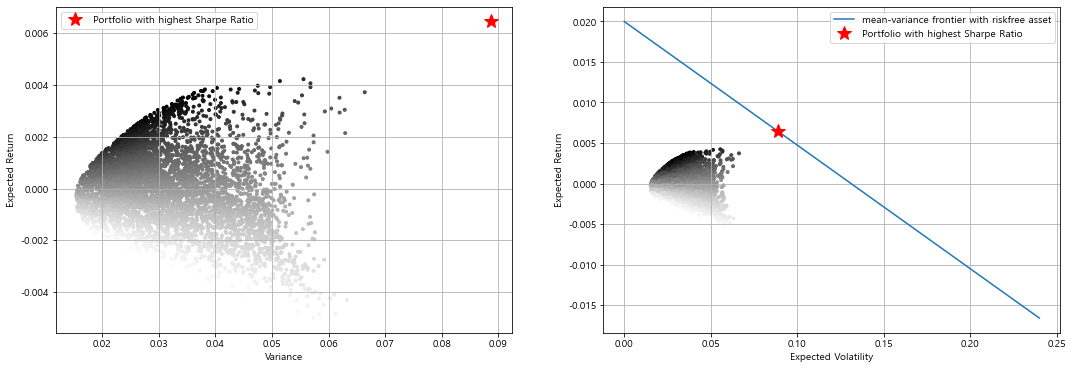

In [9]:
def statistics(weights, log_ret, rf=0):
    weights = np.array(weights)
    portfolio_return = np.sum(log_ret.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
    return np.array([portfolio_return, portfolio_volatility, sharpe_ratio])

def min_func_sharpe(weights, log_ret, rf=0):
    return -statistics(weights, log_ret, rf)[2]

def max_sharpe_portfolio(etf_data, codes, start_date, end_date, rf=0.02):
    # 날짜 형식 맞추기
    etf_data['Date'] = pd.to_datetime(etf_data['Date'])
    
    # 데이터 필터링
    filtered_data = etf_data[(etf_data['Date'] >= start_date) & (etf_data['Date'] <= end_date)]
    filtered_data.set_index('Date', inplace=True)

    # 포트폴리오 df 생성
    portfolio_df = pd.DataFrame()
    for code in codes:
        column_name = f'7_Day_Percent_Change_{code}'
        if column_name not in filtered_data.columns:
            raise KeyError(f"'{column_name}' not in ETF data columns")
        portfolio_df[code] = filtered_data[column_name]
    
    # 로그 수익률 계산
    log_ret = np.log(portfolio_df / 100 + 1).diff().dropna()
    
    noa = len(codes)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for _ in range(noa))
    init_guess = noa * [1. / noa,]

    # 최적화
    opts = minimize(min_func_sharpe, init_guess, method='SLSQP', bounds=bnds, constraints=cons, args=(log_ret, rf))

    weight = opts.x
    log_returns = log_ret.cumsum(axis=0).iloc[-1]
    portfolio_log_return = np.sum(log_returns * weight)

    cov_matrix = log_ret.cov() * 252  # 연간 변동성으로 변환
    port_variance = np.dot(weight.T, np.dot(cov_matrix, weight))
    port_volatility = np.sqrt(port_variance)

    percent_var = str(round(port_variance * 100, 2)) + '%'
    percent_vols = str(round(port_volatility * 100, 2)) + '%'
    percent_ret = str(round(portfolio_log_return * 100, 2)) + '%'

    return log_ret, portfolio_df, percent_ret, percent_vols, percent_var, weight

def plot_max_sharpe_portfolio(port_rets, port_std, noa, log_ret, portfolio_df, log_ret_data, end_date, rf=0.02):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for _ in range(noa))
    init_guess = noa * [1. / noa,]

    opts = minimize(min_func_sharpe, init_guess, method='SLSQP', bounds=bnds, constraints=cons, args=(log_ret, rf))

    weights = opts.x

    axes[0].scatter(port_std, port_rets, c=np.array(port_rets) / np.array(port_std), marker='.', cmap='Greys')
    axes[0].plot(statistics(weights, log_ret, rf)[1], statistics(weights, log_ret, rf)[0], 'r*', markersize=15.0, label='Portfolio with highest Sharpe Ratio')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_xlabel('Variance')
    axes[0].set_ylabel('Expected Return')

    slope = (statistics(weights, log_ret, rf)[0] - rf) / statistics(weights, log_ret, rf)[1]
    x = np.linspace(0.0, 0.24, 5000)
    y = [i * slope + rf for i in x]

    axes[1].scatter(port_std, port_rets, c=np.array(port_rets) / np.array(port_std), marker='.', cmap='Greys')
    axes[1].plot(x, y, label='mean-variance frontier with riskfree asset')
    axes[1].plot(statistics(weights, log_ret, rf)[1], statistics(weights, log_ret, rf)[0], 'r*', markersize=15.0, label='Portfolio with highest Sharpe Ratio')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_xlabel('Expected Volatility')
    axes[1].set_ylabel('Expected Return')

    sharpe_ratio = statistics(weights, log_ret, rf)[2]
    opt_weight = {portfolio_df.columns[i]: round(weights[i], 10) for i in range(noa)}

    return fig, sharpe_ratio, opt_weight

# 사용 예시
etf_data = data
#codes = ['SLV', 'USO', 'DBO', 'REET', 'IYR']  # 예시로 일부 ETF 사용
codes = ["UUP", "FXE", "FXY", "FXC"]
start_date = '2019-01-04'
end_date = '2020-01-04'
rf = 0.02 # 채권 수익률로...

log_ret, portfolio_df, percent_ret, percent_vols, percent_var, weights = max_sharpe_portfolio(etf_data, codes, start_date, end_date, rf)

# 랜덤 포트폴리오 생성 및 최적화
port_rets, port_std = make_random_portfolio(log_ret, len(codes), log_ret)
fig, sharpe_ratio, opt_weight = plot_max_sharpe_portfolio(port_rets, port_std, len(codes), log_ret, portfolio_df, log_ret, pd.to_datetime(end_date), rf)

# 결과 출력
print(f"최적화된 포트폴리오 비중: {opt_weight}")
print(f"샤프 비율: {sharpe_ratio}")
plt.show()


최적화된 포트폴리오 비중: {'SLV': 0.2001784919, 'USO': 0.0, 'DBO': 0.1086749131, 'REET': 0.691146595, 'IYR': 0.0}


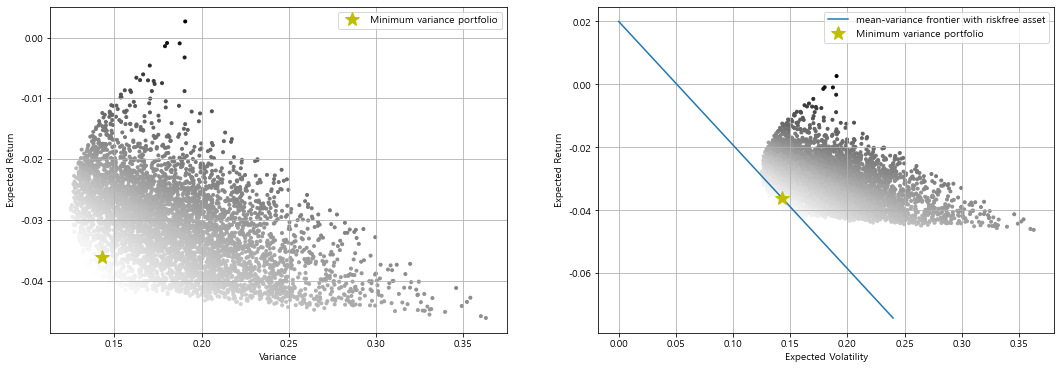

In [10]:
def statistics(weights, log_ret, rf=0):
    weights = np.array(weights)
    portfolio_return = np.sum(log_ret.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
    return np.array([portfolio_return, portfolio_volatility, sharpe_ratio])

def min_func_volatility(weights, log_ret):
    return statistics(weights, log_ret)[1] ** 2

def min_variance_portfolio(etf_data, codes, start_date, end_date):
    # 날짜 형식 맞추기
    etf_data['Date'] = pd.to_datetime(etf_data['Date'])
    
    # 데이터 필터링
    filtered_data = etf_data[(etf_data['Date'] >= start_date) & (etf_data['Date'] <= end_date)]
    filtered_data.set_index('Date', inplace=True)

    # 포트폴리오 df 생성
    portfolio_df = pd.DataFrame()
    for code in codes:
        column_name = f'7_Day_Percent_Change_{code}'
        if column_name not in filtered_data.columns:
            raise KeyError(f"'{column_name}' not in ETF data columns")
        portfolio_df[code] = filtered_data[column_name]
    
    # 로그 수익률 계산
    log_ret = np.log(portfolio_df / 100 + 1).diff().dropna()
    
    noa = len(codes)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for _ in range(noa))
    init_guess = noa * [1. / noa,]

    # 최적화
    optv = minimize(min_func_volatility, init_guess, method='SLSQP', bounds=bnds, constraints=cons, args=(log_ret,))

    weight = optv.x
    log_returns = log_ret.cumsum(axis=0).iloc[-1]
    portfolio_log_return = np.sum(log_returns * weight)

    cov_matrix = log_ret.cov() * 252  # 연간 변동성으로 변환
    port_variance = np.dot(weight.T, np.dot(cov_matrix, weight))
    port_volatility = np.sqrt(port_variance)

    percent_var = str(round(port_variance * 100, 2)) + '%'
    percent_vols = str(round(port_volatility * 100, 2)) + '%'
    percent_ret = str(round(portfolio_log_return * 100, 2)) + '%'

    return log_ret, portfolio_df, percent_ret, percent_vols, percent_var, weight

def plot_min_variance_portfolio(port_rets, port_std, noa, log_ret, portfolio_df, log_ret_data, end_date):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for _ in range(noa))
    init_guess = noa * [1. / noa,]

    optv = minimize(min_func_volatility, init_guess, method='SLSQP', bounds=bnds, constraints=cons, args=(log_ret,))

    weights = optv.x

    axes[0].scatter(port_std, port_rets, c=np.array(port_rets) / np.array(port_std), marker='.', cmap='Greys')
    axes[0].plot(statistics(weights, log_ret)[1], statistics(weights, log_ret)[0], 'y*', markersize=15.0, label='Minimum variance portfolio')
    axes[0].legend()
    axes[0].grid(True)
    axes[0].set_xlabel('Variance')
    axes[0].set_ylabel('Expected Return')

    slope = (statistics(weights, log_ret)[0] - rf) / statistics(weights, log_ret)[1]
    x = np.linspace(0.0, 0.24, 5000)
    y = [i * slope + rf for i in x]

    axes[1].scatter(port_std, port_rets, c=np.array(port_rets) / np.array(port_std), marker='.', cmap='Greys')
    axes[1].plot(x, y, label='mean-variance frontier with riskfree asset')
    axes[1].plot(statistics(weights, log_ret)[1], statistics(weights, log_ret)[0], 'y*', markersize=15.0, label='Minimum variance portfolio')
    axes[1].legend()
    axes[1].grid(True)
    axes[1].set_xlabel('Expected Volatility')
    axes[1].set_ylabel('Expected Return')

    opt_weight = {portfolio_df.columns[i]: round(weights[i], 10) for i in range(noa)}

    return fig, opt_weight

# 사용 예시
etf_data = data
codes = ['SLV', 'USO', 'DBO', 'REET', 'IYR']  # 예시로 일부 ETF 사용
start_date = '2019-01-04'
end_date = '2020-01-04'

log_ret, portfolio_df, percent_ret, percent_vols, percent_var, weights = min_variance_portfolio(etf_data, codes, start_date, end_date)

# 랜덤 포트폴리오 생성 및 최적화
port_rets, port_std = make_random_portfolio(log_ret, len(codes), log_ret)
fig, opt_weight = plot_min_variance_portfolio(port_rets, port_std, len(codes), log_ret, portfolio_df, log_ret, pd.to_datetime(end_date))

# 결과 출력
print(f"최적화된 포트폴리오 비중: {opt_weight}")
plt.show()


In [13]:
def markowitz_portfolio(codes, start_date, end_date):
    portfolio_df = pd.DataFrame()
    for code in codes:
        temp = yf.download(code, start=start_date, end=end_date)['Adj Close']
        time.sleep(0.5)
        portfolio_df = pd.concat([portfolio_df, temp], axis=1)
    portfolio_df.columns = codes

    # 로그 수익률 계산
    log_ret = portfolio_df.apply(np.log).diff().dropna()

    noa = len(codes)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for _ in range(noa))
    init_guess = noa * [1. / noa,]

    def statistics(weights):
        weights = np.array(weights)
        pret = np.sum(log_ret.mean() * weights) * len(log_ret)
        pvol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * len(log_ret), weights)))
        return np.array([pret, pvol, pret / pvol])

    def min_func_sharpe(weights):
        return -statistics(weights)[2]

    def min_func_volatility(weights):
        return statistics(weights)[1] ** 2

    results = {}

    # SLSQP 최적화
    opts_slsqp = minimize(min_func_sharpe, init_guess, method='SLSQP', bounds=bnds, constraints=cons)
    results['SLSQP'] = {'weights': opts_slsqp.x, 'statistics': statistics(opts_slsqp.x)}

    # CMA-ES 최적화
    es = cma.CMAEvolutionStrategy(init_guess, 0.5, {'bounds': [0, 1]})
    es.optimize(min_func_sharpe)
    results['CMA-ES'] = {'weights': es.result.xbest, 'statistics': statistics(es.result.xbest)}

    # Nelder-Mead 최적화
    opts_nm = minimize(min_func_sharpe, init_guess, method='Nelder-Mead', bounds=bnds, constraints=cons)
    results['Nelder-Mead'] = {'weights': opts_nm.x, 'statistics': statistics(opts_nm.x)}

    # L-BFGS-B 최적화
    opts_lbfgsb = minimize(min_func_sharpe, init_guess, method='L-BFGS-B', bounds=bnds, constraints=cons)
    results['L-BFGS-B'] = {'weights': opts_lbfgsb.x, 'statistics': statistics(opts_lbfgsb.x)}

    # Genetic Algorithm 최적화
    def evaluate(weights):
        return statistics(weights)[2],

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    toolbox = base.Toolbox()
    toolbox.register("attr_float", np.random.uniform, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, noa)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutPolynomialBounded, low=0, up=1, eta=1.0, indpb=1.0/noa)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate)

    population = toolbox.population(n=300)
    algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=100, verbose=False)
    best_ind = tools.selBest(population, 1)[0]
    results['GA'] = {'weights': best_ind, 'statistics': statistics(best_ind)}

    # PSO 최적화
    def min_func_pso(weights):
        return -evaluate(weights)[0]

    lb = [0] * noa
    ub = [1] * noa
    opts_pso, _ = pso(min_func_pso, lb, ub, swarmsize=100, maxiter=200)
    results['PSO'] = {'weights': opts_pso, 'statistics': statistics(opts_pso)}

    max_return = max(results, key=lambda x: results[x]['statistics'][0])
    min_volatility = min(results, key=lambda x: results[x]['statistics'][1])

    return results, max_return, min_volatility

# Example usage:
codes = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
start_date = '2020-01-01'
end_date = '2021-01-01'

results, max_return, min_volatility = markowitz_portfolio(codes, start_date, end_date)
print(f"Max Return Method: {max_return}, Statistics: {results[max_return]['statistics']}")
print(f"Min Volatility Method: {min_volatility}, Statistics: {results[min_volatility]['statistics']}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=449965, Thu May 23 01:40:34 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 -1.359203367189320e+00 1.0e+00 6.26e-01  3e-01  3e-01 0:00.0
    2     16 -1.302007305407216e+00 1.3e+00 6.50e-01  3e-01  3e-01 0:00.0
    3     24 -1.303690846988466e+00 1.5e+00 6.71e-01  3e-01  3e-01 0:00.0
  100    800 -1.448634421272286e+00 4.5e+02 1.71e-04  3e-07  6e-05 0:01.1
  113    904 -1.448634421272304e+00 9.2e+02 3.81e-05  3e-08  2e-05 0:01.2
Stopping search: Swarm best objective change less than 1e-08
Max Return Method: PSO, Statistics: [0.7508658  0.51832664 1.44863441]
Min Volatility Method: GA, Statistics: [0.51793623 0.3015024

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=443275, Thu May 23 01:41:46 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 4.778345165604069e-02 1.0e+00 4.78e-01  3e-01  3e-01 0:00.0
    2     16 4.667654233224110e-02 1.3e+00 4.43e-01  3e-01  3e-01 0:00.0
    3     24 1.303484331052978e-02 1.4e+00 4.16e-01  2e-01  3e-01 0:00.1
  100    800 -8.285384257496553e-02 6.7e+01 3.06e-05  4e-07  3e-05 0:01.3
  115    920 -8.285384257520879e-02 1.0e+02 6.21e-06  6e-08  5e-06 0:01.6
Max Return Method: L-BFGS-B, Statistics: [0.02426388 0.29285155 0.08285384]
Min Volatility Method: Nelder-Mead, Statistics: [0.01409812 0.17015651 0.08285384]


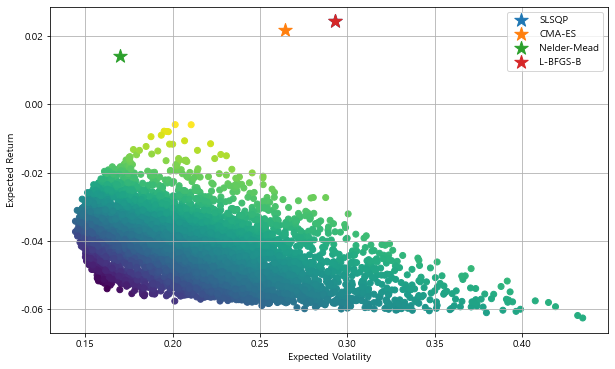

In [15]:
def statistics(weights, log_ret, rf=0):
    weights = np.array(weights)
    portfolio_return = np.sum(log_ret.mean() * weights) * 252
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility
    return np.array([portfolio_return, portfolio_volatility, sharpe_ratio])

def min_func_volatility(weights, log_ret):
    return statistics(weights, log_ret)[1] ** 2

def markowitz_portfolio(etf_data, codes, start_date, end_date):
    # 날짜 형식 맞추기
    etf_data['Date'] = pd.to_datetime(etf_data['Date'])
    
    # 데이터 필터링
    filtered_data = etf_data[(etf_data['Date'] >= start_date) & (etf_data['Date'] <= end_date)]
    filtered_data.set_index('Date', inplace=True)

    # 포트폴리오 df 생성
    portfolio_df = pd.DataFrame()
    for code in codes:
        column_name = f'7_Day_Percent_Change_{code}'
        if column_name not in filtered_data.columns:
            raise KeyError(f"'{column_name}' not in ETF data columns")
        portfolio_df[code] = filtered_data[column_name]
    
    # 로그 수익률 계산
    log_ret = np.log(portfolio_df / 100 + 1).diff().dropna()
    
    noa = len(codes)
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bnds = tuple((0, 1) for _ in range(noa))
    init_guess = noa * [1. / noa,]

    def min_func_sharpe(weights):
        return -statistics(weights, log_ret)[2]

    def min_func_volatility(weights):
        return statistics(weights, log_ret)[1] ** 2

    results = {}

    # SLSQP 최적화
    opts_slsqp = minimize(min_func_sharpe, init_guess, method='SLSQP', bounds=bnds, constraints=cons)
    results['SLSQP'] = {'weights': opts_slsqp.x, 'statistics': statistics(opts_slsqp.x, log_ret)}

    # CMA-ES 최적화
    es = cma.CMAEvolutionStrategy(init_guess, 0.5, {'bounds': [0, 1]})
    es.optimize(min_func_sharpe)
    results['CMA-ES'] = {'weights': es.result.xbest, 'statistics': statistics(es.result.xbest, log_ret)}

    # Nelder-Mead 최적화
    opts_nm = minimize(min_func_sharpe, init_guess, method='Nelder-Mead', bounds=bnds, constraints=cons)
    results['Nelder-Mead'] = {'weights': opts_nm.x, 'statistics': statistics(opts_nm.x, log_ret)}

    # L-BFGS-B 최적화
    opts_lbfgsb = minimize(min_func_sharpe, init_guess, method='L-BFGS-B', bounds=bnds, constraints=cons)
    results['L-BFGS-B'] = {'weights': opts_lbfgsb.x, 'statistics': statistics(opts_lbfgsb.x, log_ret)}

    max_return = max(results, key=lambda x: results[x]['statistics'][0])
    min_volatility = min(results, key=lambda x: results[x]['statistics'][1])

    # 랜덤 포트폴리오 생성
    num_portfolios = 5000
    all_weights = np.zeros((num_portfolios, noa))
    ret_arr = np.zeros(num_portfolios)
    vol_arr = np.zeros(num_portfolios)
    sharpe_arr = np.zeros(num_portfolios)

    for i in range(num_portfolios):
        weights = np.random.random(noa)
        weights /= np.sum(weights)

        all_weights[i,:] = weights
        ret_arr[i] = np.sum((log_ret.mean() * weights) * 252)
        vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
        sharpe_arr[i] = ret_arr[i] / vol_arr[i]

    return results, max_return, min_volatility, ret_arr, vol_arr

def plot_min_variance_portfolio(results, ret_arr, vol_arr):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.scatter(vol_arr, ret_arr, c=ret_arr/vol_arr, marker='o')
    
    for key in results:
        ax.scatter(results[key]['statistics'][1], results[key]['statistics'][0], marker='*', s=200, label=key)
    
    ax.set_xlabel('Expected Volatility')
    ax.set_ylabel('Expected Return')
    ax.legend()
    ax.grid(True)

    plt.show()

# 사용 예시
codes = ['SLV', 'USO', 'DBO', 'REET', 'IYR']  # 예시로 일부 ETF 사용
start_date = '2019-01-04'
end_date = '2020-01-04'

results, max_return, min_volatility, ret_arr, vol_arr = markowitz_portfolio(etf_data, codes, start_date, end_date)
print(f"Max Return Method: {max_return}, Statistics: {results[max_return]['statistics']}")
print(f"Min Volatility Method: {min_volatility}, Statistics: {results[min_volatility]['statistics']}")

plot_min_variance_portfolio(results, ret_arr, vol_arr)


# 투자 성향별 포트폴리오 최적화(추천) 성능 높이기...

In [15]:
# 기본 골자
def recommend_portfolio(investor_type):
    if investor_type == '안정형':
        recommended = df_portfolios.loc[df_portfolios['variance'].idxmin()]
    elif investor_type == '안정추구형':
        recommended = df_portfolios.loc[(df_portfolios['variance'] <= df_portfolios['variance'].quantile(0.5)) & (df_portfolios['return'] >= df_portfolios['return'].quantile(0.5))].sort_values(by='variance').iloc[0]
    elif investor_type == '위험중립형':
        recommended = df_portfolios.loc[(df_portfolios['volatility'] >= df_portfolios['volatility'].quantile(0.25)) & (df_portfolios['volatility'] <= df_portfolios['volatility'].quantile(0.75))].sort_values(by='return', ascending=False).iloc[0]
    elif investor_type == '적극투자형':
        recommended = df_portfolios.loc[(df_portfolios['return'] >= df_portfolios['return'].quantile(0.75))].sort_values(by='volatility').iloc[0]
    elif investor_type == '공격투자형':
        recommended = df_portfolios.loc[df_portfolios['return'].idxmax()]
    else:
        return 'Unknown investor type', {}

    return recommended.name, recommended.to_dict()